In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# DATA PATHS

TRAIN_FOLDER_PATH = '../../data/train/'
VAL_FODLER_PATH = '../../data/validation/'
#TEST_FOLDER_PATH = '../../data/test/'
TEST_FOLDER_PATH = '../../data/test_manual'
PREVIEW_IMAGES_FOLDER = '../../data/preview/'

#PREDICTION_FILE_PATH = '../../data/' + MODEL_NAME + '.csv'

In [3]:
# Configure initial hyperparameters
#img_width = 100
#img_height = 100
img_depth = 3

classes = 2
batch_size = 64
num_epochs = 20
loss = "categorical_crossentropy"
learning_rate = 1e-1
decay = 1e-1
momentum = 0.9

In [4]:
# MODEL TRAINING CONFIGURATION

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

def get_train_generator(img_height, img_width):
    train_generator = train_datagen.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size = (img_height,img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return train_generator

def get_validation_generator(img_height, img_width):
    validation_generator = validation_datagen.flow_from_directory(
        VAL_FODLER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return validation_generator

def get_test_generator(img_height, img_width):
    test_generator = test_datagen.flow_from_directory(
        TEST_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return test_generator

In [5]:
# Callbacks
def get_callbacks(model_name):    
    mc = ModelCheckpoint('best_' + model_name + '.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor = 'val_MCC', patience=10, verbose=1, mode='max')
    reduce_lr = ReduceLROnPlateau(patience=2)
    
    return [mc, es, reduce_lr]

In [6]:
# Compile the model
def compile_model(model):
    opt = SGD(lr=learning_rate, momentum=momentum, decay=decay / num_epochs)

    model.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])
    
    return model

In [7]:
# Fit the model
def fit_model(model, train_generator, validation_generator, model_name):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,
        epochs = num_epochs,
        validation_data = validation_generator,
        validation_steps = validation_generator.n // validation_generator.batch_size,
        use_multiprocessing = False,
        workers=1,
        callbacks = get_callbacks(model_name)
    )
    
    return history, model

In [8]:
# Save model
def save_model(model, model_name):
    model.save(model_name + '.h5')

In [9]:
# Evaluate the model
def evaluate_model(model, validation_generator):
    return model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

In [10]:
# Predictions
def get_predictions(model, test_generator):
    test_generator.reset()

    predIdxs = model.predict_generator(test_generator,steps=(test_generator.n // test_generator.batch_size) + 1)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    predIdxs = np.argmax(predIdxs, axis=1)
    
    return predIdxs

In [11]:
# Plot accuracy and loss values
def plot_metrics(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    # summarize history for loss
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    # Plot MCC values
    plt.subplot(2,2,3)
    plt.plot(history.history['MCC'])
    plt.plot(history.history['val_MCC'])
    plt.title('model MCC')
    plt.ylabel('MCC')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

In [12]:
# Show evaluation metrics
def show_eval_metrics(model, metrics):
    for idx, m in enumerate(model.metrics_names):
        print("{}: {:.4f}".format(m, metrics[idx]))

In [13]:
# Show test metrics
def show_test_metrics(predictions, test_generator):
    print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(test_generator.classes, predictions)
    total = sum(sum(cm))
    acc = (cm[0,0] + cm[1,1]) / total
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
    specificity = cm[1,1] / (cm[1,0] + cm[1,1])

    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))

### Create the first model for images of 65x65

In [14]:
# Model architecture for the first size

MODEL_1_NAME = "model_1"

img_width = 36
img_height = 36

model_1 = Sequential()

model_1.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.25))
model_1.add(BatchNormalization())

model_1.add(Conv2D(64, (3, 3), padding="same"))
model_1.add(Activation("relu"))
model_1.add(Conv2D(64, (3, 3), padding="same"))
model_1.add(Activation("relu"))

model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(BatchNormalization())

model_1.add(Conv2D(128, (3, 3), padding="same"))
model_1.add(Activation("relu"))
model_1.add(Conv2D(128, (3, 3), padding="same"))
model_1.add(Activation("relu"))
model_1.add(Conv2D(128, (3, 3), padding="same"))
model_1.add(Activation("relu"))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(classes))
model_1.add(Activation("softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 18, 18, 64)        0

In [15]:
# Compile
model_1 = compile_model(model_1)

In [16]:
#Create the generators
train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)
test_generator = get_test_generator(img_height, img_width)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [17]:
# Train
history, model_1 = fit_model(model_1, train_generator, validation_generator, MODEL_1_NAME)

W0619 06:08:10.037034 139850191050560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
321/322 [============================>.] - ETA: 0s - loss: 0.5464 - accuracy: 0.7173 - MCC: 0.4346
Epoch 00001: val_MCC improved from -inf to 0.85283, saving model to best_model_1.h5
322/322 [==============================] - 26s 80ms/step - loss: 0.5456 - accuracy: 0.7178 - MCC: 0.4355 - val_loss: 0.2450 - val_accuracy: 0.9264 - val_MCC: 0.8528
Epoch 2/20
321/322 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9278 - MCC: 0.8556
Epoch 00002: val_MCC did not improve from 0.85283
322/322 [==============================] - 24s 73ms/step - loss: 0.2150 - accuracy: 0.9279 - MCC: 0.8558 - val_loss: 0.2090 - val_accuracy: 0.9179 - val_MCC: 0.8358
Epoch 3/20
321/322 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9416 - MCC: 0.8831
Epoch 00003: val_MCC did not improve from 0.85283
322/322 [==============================] - 23s 73ms/step - loss: 0.1816 - accuracy: 0.9416 - MCC: 0.8832 - val_loss: 0.2107 - val_accuracy: 0.9211 - val_MCC

In [18]:
# Save model
save_model(model_1, MODEL_1_NAME)

In [19]:
# Evaluate
metrics = evaluate_model(model_1, validation_generator)
show_eval_metrics(model_1, metrics)

loss: 0.1953
accuracy: 0.9313
MCC: 0.8626


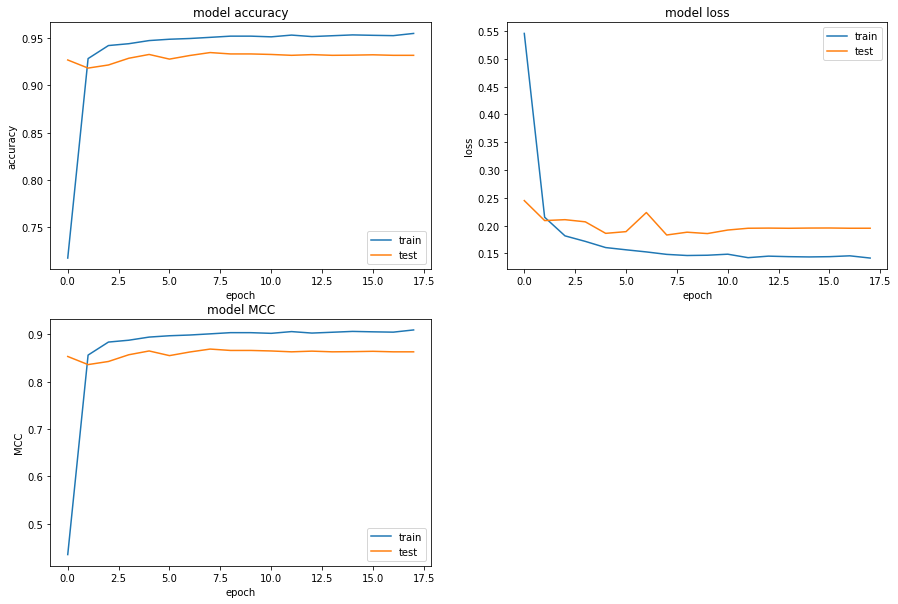

In [20]:
# Plot metrics from history
plot_metrics(history)

In [21]:
# Predict
predictions = get_predictions(model_1, test_generator)

In [22]:
# Show final metrics
show_test_metrics(predictions, test_generator)

              precision    recall  f1-score   support

 parasitized       0.93      0.93      0.93       688
  uninfected       0.93      0.93      0.93       688

    accuracy                           0.93      1376
   macro avg       0.93      0.93      0.93      1376
weighted avg       0.93      0.93      0.93      1376

acc: 0.9310
sensitivity: 0.9288
specificity: 0.9331


### Create next model with a size of images of 130x130

In [23]:
# Configure the new size for the images
MODEL_2_NAME = "model_2"

img_height = 72
img_width = 72

# Create the new model.
# Add an input layer for the new size, then apply MaxPooling to downsample to the size of the previous model
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3,3), padding="same"))

# Load the pretrained model
prior = load_model(MODEL_1_NAME + '.h5', custom_objects={'MCC': MCC})

#for i, layer in enumerate(model_2.layers):
#    print(i, layer.name, layer.input_shape, layer.output_shape)

#for i, layer in enumerate(prior.layers[1:]):
#    print(i, layer.name, layer.input_shape, layer.output_shape)

# Stack the new model over the old one, removing the original input layers
#for layer in prior.layers[5:]:
for layer in prior.layers[1:]:
    layer.trainable = False
    model_2.add(layer)

#for layer in prior.layers[-3:]:
    #print(layer.name, layer.trainable)
#    layer.trainable = True
#    model_2.add(layer)
    
#for layer in model_2.layers:
#    print(layer.name, layer.input_shape, layer.output_shape, layer.trainable)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
activation (Activation)      (None, 36, 36, 32)       

In [24]:
# Compile
model_2 = compile_model(model_2)

In [25]:
#Create the generators
train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)
test_generator = get_test_generator(img_height, img_width)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [26]:
# Train
history, model_2 = fit_model(model_2, train_generator, validation_generator, MODEL_2_NAME)

Epoch 1/20
321/322 [============================>.] - ETA: 0s - loss: 0.4439 - accuracy: 0.7903 - MCC: 0.5806
Epoch 00001: val_MCC improved from -inf to 0.00109, saving model to best_model_2.h5
322/322 [==============================] - 33s 103ms/step - loss: 0.4430 - accuracy: 0.7908 - MCC: 0.5816 - val_loss: 2.6968 - val_accuracy: 0.5005 - val_MCC: 0.0011
Epoch 2/20
321/322 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9403 - MCC: 0.8805
Epoch 00002: val_MCC did not improve from 0.00109
322/322 [==============================] - 32s 101ms/step - loss: 0.1774 - accuracy: 0.9403 - MCC: 0.8806 - val_loss: 3.4972 - val_accuracy: 0.5005 - val_MCC: 0.0011
Epoch 3/20
321/322 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9441 - MCC: 0.8882
Epoch 00003: val_MCC did not improve from 0.00109
322/322 [==============================] - 32s 101ms/step - loss: 0.1689 - accuracy: 0.9442 - MCC: 0.8884 - val_loss: 2.4234 - val_accuracy: 0.5005 - val_

In [27]:
# Save model
save_model(model_2, MODEL_2_NAME)

In [28]:
# Evaluate
metrics = evaluate_model(model_2, validation_generator)
show_eval_metrics(model_2, metrics)

loss: 2.4982
accuracy: 0.5009
MCC: 0.0018


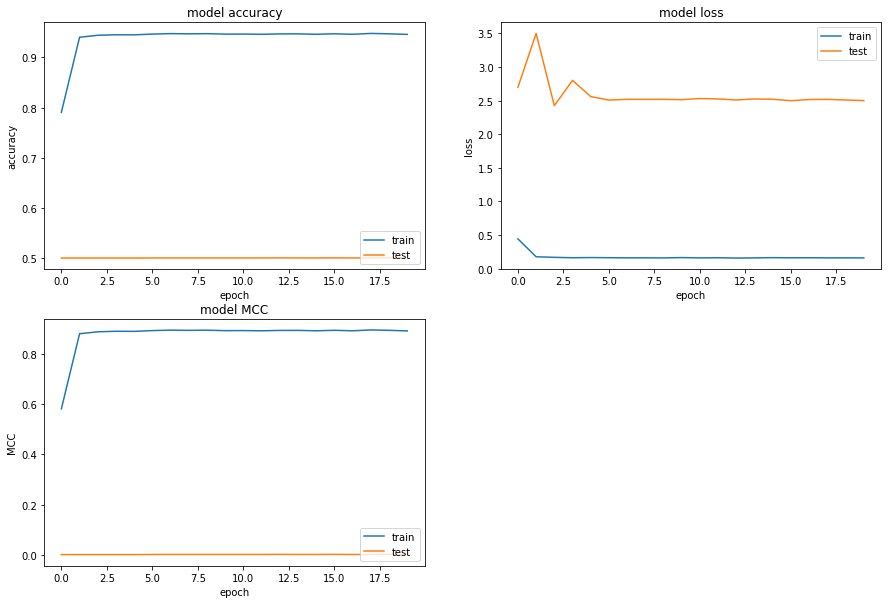

In [29]:
# Plot metrics from history
plot_metrics(history)

In [30]:
# Predict
predictions = get_predictions(model_2, test_generator)

In [31]:
# Show final metrics
show_test_metrics(predictions, test_generator)

              precision    recall  f1-score   support

 parasitized       0.50      1.00      0.67       688
  uninfected       0.00      0.00      0.00       688

    accuracy                           0.50      1376
   macro avg       0.25      0.50      0.33      1376
weighted avg       0.25      0.50      0.33      1376

acc: 0.5000
sensitivity: 1.0000
specificity: 0.0000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Create next model with a size of images of 260x260

In [32]:
# Create a new model for the next size and train
MODEL_3_NAME = "model_3"

img_height = 144
img_width = 144

model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))
model_3.add(BatchNormalization())
model_3.add(Conv2D(32, (3,3), padding="same"))

# Load the pretrained model
prior = load_model(MODEL_2_NAME + '.h5', custom_objects={'MCC': MCC})
#prior.summary()

# Stack the new model over the old one, removing the original input layers
for layer in prior.layers[1:]:
    layer.trainable = False
    model_3.add(layer)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 144, 144, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 144, 144, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 72, 72, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)       

In [33]:
# Compile
model_3 = compile_model(model_3)

In [34]:
#Create the generators
train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)
test_generator = get_test_generator(img_height, img_width)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [35]:
# Train
history, model_3 = fit_model(model_3, train_generator, validation_generator, MODEL_3_NAME)

Epoch 1/20
321/322 [============================>.] - ETA: 0s - loss: 0.5445 - accuracy: 0.7347 - MCC: 0.4695
Epoch 00001: val_MCC improved from -inf to 0.00109, saving model to best_model_3.h5
322/322 [==============================] - 70s 218ms/step - loss: 0.5434 - accuracy: 0.7353 - MCC: 0.4708 - val_loss: 8.0503 - val_accuracy: 0.5005 - val_MCC: 0.0011
Epoch 2/20
321/322 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9422 - MCC: 0.8843
Epoch 00002: val_MCC did not improve from 0.00109
322/322 [==============================] - 69s 214ms/step - loss: 0.1751 - accuracy: 0.9422 - MCC: 0.8844 - val_loss: 8.0503 - val_accuracy: 0.5005 - val_MCC: 0.0011
Epoch 3/20
321/322 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9447 - MCC: 0.8894
Epoch 00003: val_MCC did not improve from 0.00109
322/322 [==============================] - 69s 214ms/step - loss: 0.1726 - accuracy: 0.9446 - MCC: 0.8892 - val_loss: 8.0503 - val_accuracy: 0.5005 - val_

In [36]:
# Save model
save_model(model_3, MODEL_3_NAME)

In [37]:
# Evaluate
metrics = evaluate_model(model_3, validation_generator)
show_eval_metrics(model_3, metrics)

loss: 8.0503
accuracy: 0.5005
MCC: 0.0011


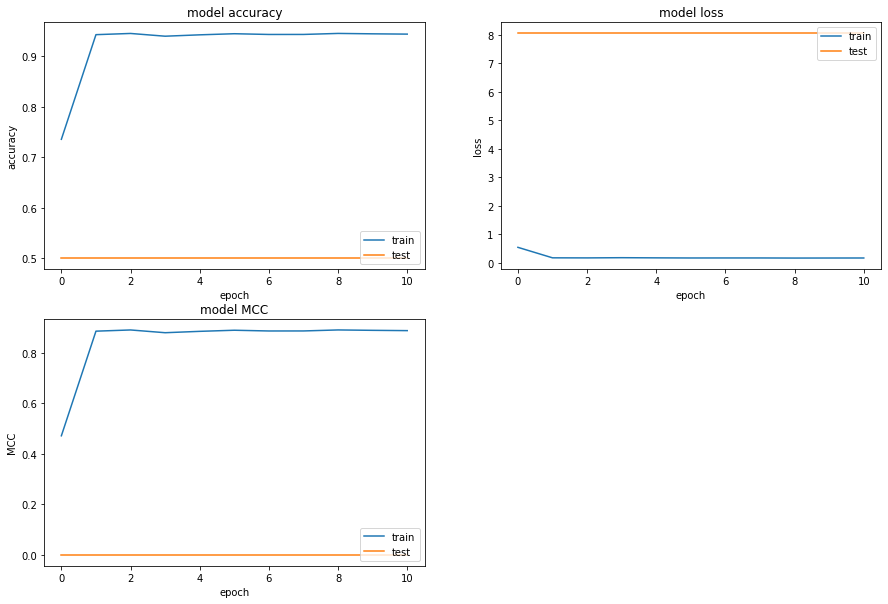

In [38]:
# Plot metrics from history
plot_metrics(history)

In [39]:
# Predict
predictions = get_predictions(model_3, test_generator)

In [40]:
# Show final metrics
show_test_metrics(predictions, test_generator)

              precision    recall  f1-score   support

 parasitized       0.50      1.00      0.67       688
  uninfected       0.00      0.00      0.00       688

    accuracy                           0.50      1376
   macro avg       0.25      0.50      0.33      1376
weighted avg       0.25      0.50      0.33      1376

acc: 0.5000
sensitivity: 1.0000
specificity: 0.0000
